In [1]:
%matplotlib inline
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from pandas import DataFrame

from fancy import Data, Model, Analysis
from fancy.interfaces.stan import get_simulation_input

In [2]:
import healpy

In [3]:
'''Setting up'''

# Define location of Stan files
stan_path = '../../stan/'

# Define file containing source catalogue information
source_file = '../../data/sourcedata.h5'

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# source_types = ["SBG_23", "2FHL_250Mpc", "swift_BAT_213"]
source_type = "SBG_23"

# detector_types = ["auger2010", "auger2014", "TA2015"]
# detector_type = "auger2014"
detector_type = "TA2015"

# set random seed
random_seed = 19990308

# flag to control showing plots or not
show_plot = True

In [4]:
'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Undefined detector type!")


In [5]:
'''Create joint simulated dataset'''

# Define a Stan simulation to run
sim_name = stan_path + 'joint_gmf_model_sim.stan' # simulate all processes

# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile(reset=False)

print("Current Source: {0}".format(source_type))
# define separate files
table_file = '../../tables/tables_{0}_{1}.h5'.format(source_type, detector_type)
sim_output_file = 'output/joint_gmf_model_simulation_{0}_{1}.h5'.format(source_type, detector_type)

# Define a source catalogue and detector exposure
# In the paper we use the SBG catalogue
data = Data()
data.add_source(source_file, source_type)
data.add_detector(detector_properties)

# Plot the sources in Galactic coordinates
# if show_plot:
#     data.show();

# Define associated fraction
f = 0.5 

# Simulation input
B = 20 # nG
alpha = 3.0
Eth = Eth   
Eth_sim = 20 # EeV
ptype="p"

# number of simulated inputs
# changes the background flux linearly
# should choose Nsim such that FT is the same for
# each observatory
# this ensures that L, F0 are the same
# 
# for PAO, we saw that FT, detector_type = 0.3601
FT_PAO = 0.3601   # total, detector_type flux using {1} data with Nsim = 2500, detector_type
Nsim_expected = FT_PAO / (M / alpha_T)
Nsim = int(np.round(Nsim_expected))

# check value for Nsim
print("Simulated events: {0}".format(Nsim))


# L in yr^-1, F in km^-2 yr^-1
L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

# To scale between definition of flux in simulations and fits
flux_scale = (Eth / Eth_sim)**(1 - alpha)

simulation.input(B = B, L = L, F0 = F0,
            alpha = alpha, Eth = Eth, ptype=ptype)

# check luminosity and isotropic flux values
# L ~ O(10^39), F0 ~ 0.18
# same luminosity so only need to check one value
print("Simulated Luminosity: {0:.3e}".format(L[0]))
print("Simulated isotropic flux: {0:.3f}".format(F0))


# What is happening 
summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
# summary = b'Simulation using the joint model and Swift-BAT catalogue' # must be a byte str
    
# Define an Analysis object to bring together Data and Model objects
sim_analysis = Analysis(data, simulation, analysis_type = 'joint_gmf', 
                    filename = sim_output_file, summary = summary)

print("Building tables...")

# Build pre-computed values for the simulation as you go
# So that you can try out different parameters
sim_analysis.build_tables(sim_only = True)



Using cached StanModel
Current Source: SBG_23
Simulated events: 451
Simulated Luminosity: 3.351e+39
Simulated isotropic flux: 0.180
Building tables...


Precomputing exposure integral: 100%|██████████| 23/23 [00:01<00:00, 12.90it/s]

In [6]:
from fancy.interfaces.stan import convert_scale

eps = sim_analysis.tables.sim_table

# handle selected sources
if (sim_analysis.data.source.N < len(eps)):
    eps = [eps[i] for i in sim_analysis.data.source.selection]

# convert scale for sampling
D = sim_analysis.data.source.distance
alpha_T = sim_analysis.data.detector.alpha_T
L = sim_analysis.model.L
F0 = sim_analysis.model.F0
D, alpha_T, eps, F0, L = convert_scale(D, alpha_T, eps, F0, L)

if sim_analysis.analysis_type == sim_analysis.joint_type or sim_analysis.analysis_type == sim_analysis.E_loss_type:
    # find lower energy threshold for the simulation, given Eth and Eerr
    if Eth_sim:
        sim_analysis.model.Eth_sim = Eth_sim

# compile inputs from Model and Data
sim_analysis.simulation_input = {
    'kappa_d': sim_analysis.data.detector.kappa_d,
    'Ns': len(sim_analysis.data.source.distance),
    'varpi': sim_analysis.data.source.unit_vector,
    'D': D,
    'A': sim_analysis.data.detector.area,
    'a0': sim_analysis.data.detector.location.lat.rad,
    'lon': sim_analysis.data.detector.location.lon.rad,
    'theta_m': sim_analysis.data.detector.threshold_zenith_angle.rad,
    'alpha_T': alpha_T,
    'eps': eps
}

sim_analysis.simulation_input['L'] = L
sim_analysis.simulation_input['F0'] = F0
sim_analysis.simulation_input['distance'] = sim_analysis.data.source.distance
if sim_analysis.analysis_type == sim_analysis.arr_dir_type or sim_analysis.analysis_type == sim_analysis.E_loss_type:

    sim_analysis.simulation_input['kappa'] = sim_analysis.model.kappa

if sim_analysis.analysis_type == sim_analysis.E_loss_type:

    sim_analysis.simulation_input['alpha'] = sim_analysis.model.alpha
    sim_analysis.simulation_input['Eth'] = sim_analysis.model.Eth_sim
    sim_analysis.simulation_input[
        'Eerr'] = sim_analysis.data.detector.energy_uncertainty

if sim_analysis.analysis_type == sim_analysis.joint_type:

    sim_analysis.simulation_input['B'] = sim_analysis.model.B
    sim_analysis.simulation_input['alpha'] = sim_analysis.model.alpha
    sim_analysis.simulation_input['Eth'] = sim_analysis.model.Eth_sim
    sim_analysis.simulation_input[
        'Eerr'] = sim_analysis.data.detector.energy_uncertainty

if sim_analysis.analysis_type == sim_analysis.gmf_type:

    sim_analysis.simulation_input['B'] = sim_analysis.model.B
    sim_analysis.simulation_input['alpha'] = sim_analysis.model.alpha
    sim_analysis.simulation_input['Eth'] = sim_analysis.model.Eth_sim
    sim_analysis.simulation_input[
        'Eerr'] = sim_analysis.data.detector.energy_uncertainty

    # get particle type we intialize simulation with
    sim_analysis.ptype = sim_analysis.model.ptype
    _, Z = sim_analysis.nuc_table[sim_analysis.ptype]
    sim_analysis.simulation_input["Z"] = Z

try:
    if sim_analysis.data.source.flux:
        sim_analysis.simulation_input['flux'] = sim_analysis.data.source.flux
    else:
        sim_analysis.simulation_input['flux'] = np.zeros(sim_analysis.data.source.N)
except:
    sim_analysis.simulation_input['flux'] = np.zeros(sim_analysis.data.source.N)

# run simulation
print('Running Stan simulation...')
sim_analysis.simulation = sim_analysis.model.simulation.sampling(
    data=sim_analysis.simulation_input,
    iter=1,
    chains=1,
    algorithm="Fixed_param",
    seed=random_seed)

# extract output
print('Extracting output...')

sim_analysis.Nex_sim = sim_analysis.simulation.extract(['Nex_sim'])['Nex_sim']
sim_analysis.source_labels = (
    sim_analysis.simulation.extract(['lambda'])['lambda'][0] - 1).astype(int)

sim_analysis.N = len(sim_analysis.source_labels)

# if sim_analysis.analysis_type == sim_analysis.joint_type or sim_analysis.analysis_type == sim_analysis.E_loss_type:

    # sim_analysis.Edet = sim_analysis.simulation.extract(['Edet'])['Edet'][0]
sim_analysis.Earr = sim_analysis.simulation.extract(['Earr'])['Earr'][0]
sim_analysis.E = sim_analysis.simulation.extract(['E'])['E'][0]

Running Stan simulation...
Extracting output...


In [9]:
# extract outputs
kappas = sim_analysis.simulation.extract(['kappa'])['kappa'][0]  # deflection parameter from source
# kappas = kappas[~np.isnan(kappas)]  # remove nans, which correspond to background effects
source_labels = sim_analysis.source_labels  # to which source label each UHECR is associated with
varpi = sim_analysis.data.source.unit_vector

# get source vector in which uhecr is associated with
varpi_per_uhecr = []
for lmbda in source_labels:
    if lmbda != len(varpi):  # if not background
        varpi_per_uhecr.append(np.array(varpi[lmbda]))
    else:
        varpi_per_uhecr.append(None)

In [11]:
src_indices = np.argwhere(source_labels != len(varpi))   # index of sources
bg_indices = np.argwhere(source_labels == len(varpi))  # index of background

In [12]:
# Evaluate arrival directions to generate map at gal. boundary
from fancy.detector.vMF.vmf import sample_vMF, sample_sphere
from fancy.interfaces.stan import uv_to_coord
N_uhecr = sim_analysis.N
Nrand = 100

# obtain arrival directions without gmf
# convert to SkyCoord to easily get glon / glat
# nogmf_arrdirs_bg = []
# nogmf_arrdirs_src = []
nogmf_arrdirs = []
for i, lmbda in enumerate(source_labels):
    if lmbda == len(varpi):  # if background, sample from sphere uniformly
        # nogmf_arrdirs_bg.append(uv_to_coord(sample_sphere(1, Nrand)))
        nogmf_arrdirs.append(uv_to_coord(sample_sphere(1, Nrand)))
    else:   # not background, sample from vmf
        # nogmf_arrdirs_src.append(uv_to_coord(sample_vMF(varpi_per_uhecr[i], kappas[i], Nrand)))
        nogmf_arrdirs.append(uv_to_coord(sample_vMF(varpi_per_uhecr[i], kappas[i], Nrand)))

# print(np.linalg.norm(nogmf_arrdirs, axis=2))

## Checking our obtained results

By comparing the values of $\kappa$ for each UHECR (associated to some source) and the vMF-sampled arrival directions (thrown up to $N_{rand}$ times), we note the following:
- Those at the edges (lons ~ 120, 150) have a low kappa value (1.64, 0.53 resp.) , which is alo prevalent on the map
- The source located near the South Galactic pole (82, -87) has a super high kappa value of 111, which is also clear on the map.
- The big cluster at lons in [30, 60] deg is a result of the accumulation of many sources near that area, as most of these sources do not have a substantiatlly high kappa value (max ~ 10)
- Those at the left edge (lons ~ -125, -134) have kappa values of (24, 6) resp., but is not that obvious in the map.

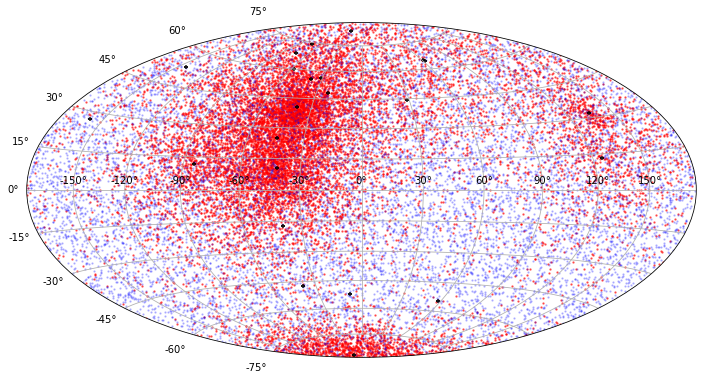

In [13]:
lons = np.array([nogmf_arrdir.galactic.l.rad for nogmf_arrdir in nogmf_arrdirs])
lats = np.array([nogmf_arrdir.galactic.b.rad for nogmf_arrdir in nogmf_arrdirs])

# lons_src = lons[src_index]
# lats_src = lats[src_index]
# lons_bg = lons[bg_index]
# lats_bg = lats[bg_index]

lons_src_true = sim_analysis.data.source.coord.galactic.l.rad
lats_src_true = sim_analysis.data.source.coord.galactic.b.rad

# in mpl coordinates:
# lons \in [-pi, pi], lats \in [-pi/2, pi/2]
# this is why we shift by np.pi from SkyCoord coordinates

plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection="hammer")
ax.scatter(-(np.pi - lons[src_indices]), lats[src_indices], s=2.0, color="r", alpha=0.5)
ax.scatter(-(np.pi - lons[bg_indices]), lats[bg_indices], s=2.0, color="b", alpha=0.2)
ax.scatter(-(np.pi - lons_src_true), lats_src_true, s=10.0, color="k", alpha=0.9, marker="+")
ax.grid()

In [14]:
import sys
sys.path.append("/opt/CRPropa3/lib/python3.8/site-packages")
import crpropa
import matplotlib.cm as cm

In [16]:
# create map of uhecrs at gal. boundary using crpropa



nogmf_energy = sim_analysis.Earr * crpropa.EeV

pid = crpropa.nucleusId(1,1)
Z = 1


M = crpropa.ParticleMapsContainer()

# for i in src_indices:
for i in range(N_uhecr):
    for j in range(Nrand):
        c_gal = nogmf_arrdirs[i][j].galactic
        # this works with the sampling scheme, considering all the flips that occur within the
        # mapping + sampling process. So we will stick to this coordinate transformation.
        M.addParticle(pid, np.float64(nogmf_energy[i]) / Z, np.pi - c_gal.l.rad,  c_gal.b.rad)



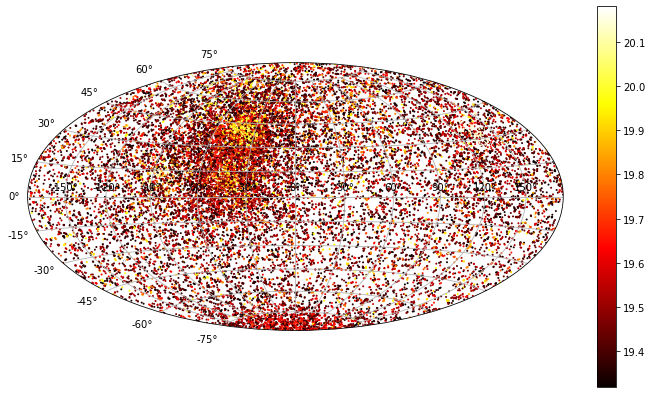

In [17]:
# now generate individual particles from lensed map
# lon \in [-pi, pi], lats \in [-pi/2, pi/2]
pids, energies, lons, lats = M.getRandomParticles(26000)

# print(np.min(lats), np.max(lats))

# create a scatter plot of the particles
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection='hammer')
sc = ax.scatter(-lons, lats, c=np.log10(Z * energies), cmap=cm.hot, lw=0, s=4.0)
ax.grid()
fig.colorbar(sc)
# plt.savefig('scattered_particles.png')

In [18]:
# plot map of uhecrs at galactic boundary
import healpy 

NPIX = M.getNumberOfPixels()  # defaultly set to 49152 from internals in CRPropa docs

NSIDE = healpy.npix2nside(NPIX)

print(
    "Approximate resolution at NSIDE = {} is {:.2} deg".format(
        NSIDE, healpy.nside2resol(NSIDE, arcmin=True) / 60
    )
)


Approximate resolution at NSIDE = 64 is 0.92 deg


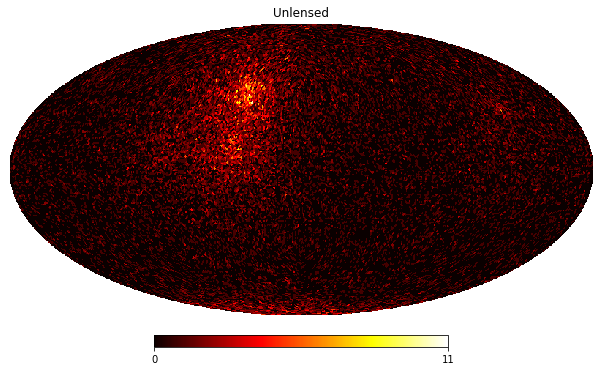

In [19]:
NPIX = 49152
#stack all maps
crMap_unlensed = np.zeros(NPIX)
energies = M.getEnergies(int(pid))
for energy in energies:
    crMap_unlensed += M.getMap(int(pid), energy * crpropa.eV )

#plot maps using healpy
# need to rotate 90 degrees to get the same output
healpy.mollview(map=crMap_unlensed, title='Unlensed', rot=(0, 0, 0), cmap=cm.hot)

# healpy.graticule()
# plt.savefig('unlensed_map.png')

In [20]:
# apply lens of b-field model to get map of uhecrs at earth
lens = crpropa.MagneticLens('JF12full_Gamale/lens.cfg')
lens.normalizeLens()
M.applyLens(lens)

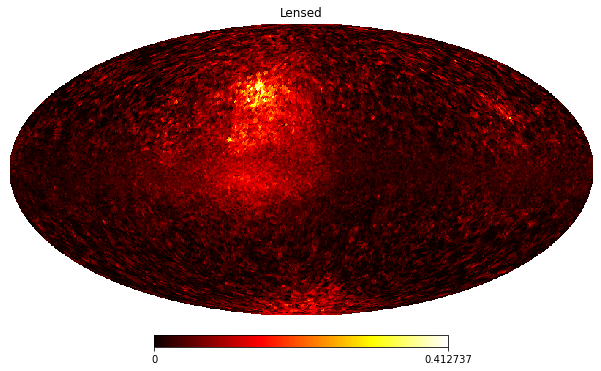

In [21]:


#stack all maps
crMap_lensed = np.zeros(49152)
energies = M.getEnergies(int(pid))
# print(energies)
for i, energy in enumerate(energies):
    crMap_lensed += M.getMap(int(pid), energy * crpropa.eV )

#plot maps using healpy
healpy.mollview(map=crMap_lensed, title='Lensed', rot=(0, 0, 0), cmap=cm.hot)
# plt.savefig('lensed_map.png')

In [24]:
# healpy.mollview(map=map_unlensed, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
ipixs = np.arange(0, 49152, 1, dtype=int)
th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
lons_crmap, lats_crmap = np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# UHECR at earth after lensing

max_count = int(np.max(crMap_unlensed))
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import matplotlib.cm as cm
from fancy.plotting.allskymap_cartopy import AllSkyMapCartopy as AllSkyMap

grid_lons, grid_lats = np.mgrid[-200:200:50j, -90:90:50j]

grid_map_unlensed = griddata((lons_crmap, lats_crmap), crMap_unlensed / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
im = skymap.ax.contourf(grid_lons, grid_lats, grid_map_unlensed, transform=ccrs.PlateCarree(), cmap=cm.afmhot_r, levels=np.linspace(0, 1, 50), alpha=1)
skymap.ax.set_facecolor('w')
skymap.title("UHECR Map at Galactic Boundary")
cbar = skymap.fig.colorbar(im,  pad=0.1,
                                cmap=cm.hot_r,
                                orientation='horizontal',
                                alpha=1, shrink=0.65)

# cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

# cbar.set_alpha(im.alpha)
# cbar.draw_all()

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

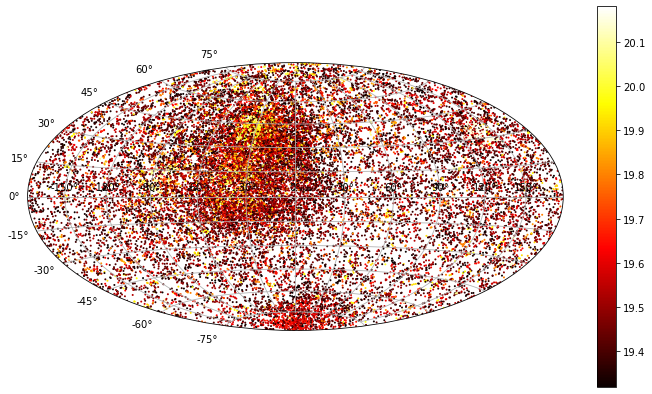

In [31]:
# now generate individual particles from lensed map
# lon \in [-pi, pi], lats \in [-pi/2, pi/2]
pids, energies, lons, lats = M.getRandomParticles(26000)

# print(np.min(lats), np.max(lats))

# create a scatter plot of the particles
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection='hammer')
sc = ax.scatter(-lons, lats, c=np.log10(Z * energies), cmap=cm.hot, lw=0, s=4.0)
ax.grid()
fig.colorbar(sc)
# plt.savefig('scattered_particles.png')

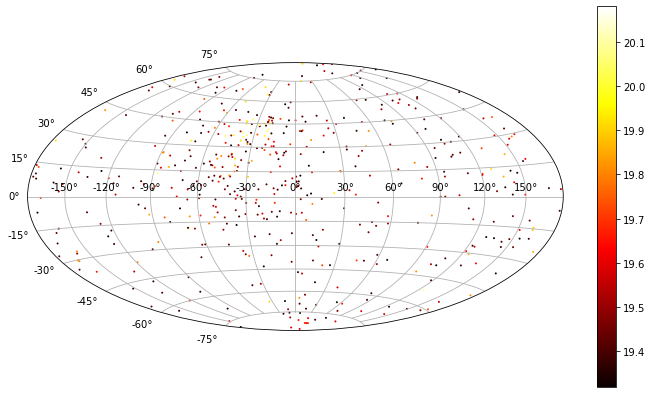

In [32]:
# sample omega_det by vMF distribution
# also need to account for exposure. do this by copying exposure_limited_vMF_rng
# but with vMF parameter as angular uncertainty

# convert lons, lats -> SkyCoord -> unit vector
# note that SkyCoord defines lon from [0, 2pi] and lat from [-90, 90] (in rad)

# now generate individual particles from lensed map
# lon \in [-pi, pi], lats \in [-pi/2, pi/2]
N = int(N_uhecr * 2)
pids, energies, lons, lats = M.getRandomParticles(N)

# print(np.min(lats), np.max(lats))

# create a scatter plot of the particles
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection='hammer')
sc = ax.scatter(-lons, lats, c=np.log10(Z * energies), cmap=cm.hot, lw=0, s=4.0)
ax.grid()
fig.colorbar(sc)
# plt.savefig('scattered_particles.png')

from astropy.coordinates import SkyCoord
from astropy import units as u
from fancy.interfaces.stan import coord_to_uv

coords = SkyCoord(-(np.pi - lons) * u.rad, lats * u.rad, frame="galactic")

# # create a scatter plot of the particles
# fig = plt.figure(figsize=(12,7))
# ax = plt.subplot(111, projection='hammer')
# sc = ax.scatter(np.pi - coords.galactic.l.rad, coords.galactic.b.rad, c=np.log10(Edet), lw=0)
# ax.grid()
# fig.colorbar(sc)


# omega_true = np.array([coord_to_uv(coord) for coord in coords])
omega_true = np.array(coord_to_uv(coords))



<Figure size 504x360 with 0 Axes>

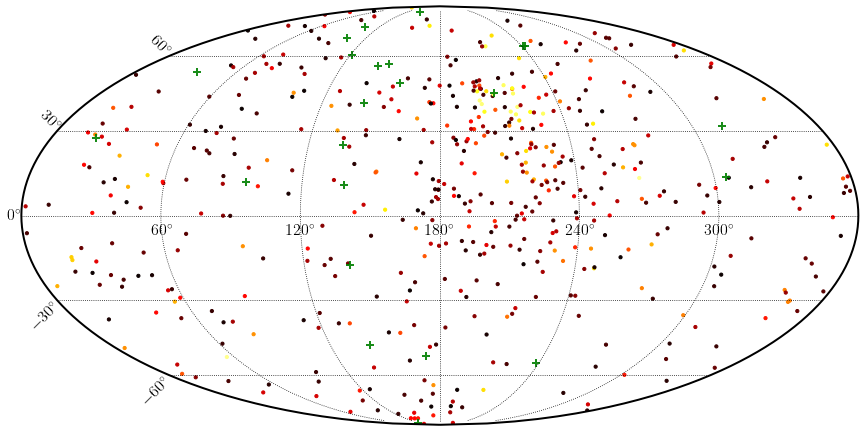

In [38]:
from fancy.plotting.allskymap_cartopy import AllSkyMapCartopy as AllSkyMap

plt.style.use("minimalist")

lons_earth, lats_earth = 180 - coords.galactic.l.deg, coords.galactic.b.deg
lons_src, lats_src = 180 - sim_analysis.data.source.coord.galactic.l.deg, sim_analysis.data.source.coord.galactic.b.deg

skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)

sc = skymap.scatter(lons_earth, lats_earth, s=10.0, color=np.log10(energies), cmap=cm.hot, alpha=1, label="UHECR from Sources", marker="o")
skymap.scatter(lons_src, lats_src, s=50.0, color="g", alpha=0.9, marker="+", label="Sources")

In [302]:
# apply exposure limits to simulated detected arrival directions
# Calculate the exposure as a function of declination
'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_params, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_params, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_params, Eth
else:
    raise Exception("Undefined detector type!")

from fancy.detector.exposure import m_dec
from scipy.stats import bernoulli

num_points = 220
rightascensions = np.linspace(-180, 180, num_points)
declinations = np.linspace(-np.pi/2, np.pi/2, num_points)

# exposure function in full declination width
m_full = np.asarray([m_dec(d, detector_params) for d in declinations])
exposure_factor = m_full / np.max(m_full)
# kappa_d correlating to angular uncertainty
kappa_d = sim_analysis.data.detector.kappa_d


In [303]:
# evaluated the exposure limited arrival direction
# sample from rejection sampling + vMF
'''
Basic algorithm:
0. Initialize an accepted-rejected container, full of zeros. This will be updated for each iteration with 1's, and 
   loop terminates when this array only contains 1's (i.e. all directions accepted).
1. sample from vMF distribution with ang_err as spread for ALL directions
2. evaluate the probability to detect the UHECR at that declination based on exposure function m(dec_det)
3. use Bernoulli distribution (2-D categorical distribution) to sample accepted (1) or rejected (0) for
   each sampled direction, based on pdet above.
4. find the indices that are (a) are not accepted by the accepted-rejected container, and (b) where the sampled values
   are only the accepted ones
5. append them to the container with same indices
6. append the corresponding omega_det with those indices only.
7. terminate when either (a) all values in container are accepted ones, or (b) the count limit is exceeded (1e7 as per stan code)
'''
omega_det_exp_limited = np.zeros((N, 3))

accepted_rejected_container = np.zeros(N)
count = 0

while len(np.nonzero(accepted_rejected_container)) != N:
    # sample from vMF distribution with angular uncertainty
    omega_det = np.array([sample_vMF(omega_true_i, kappa_d, 1) for omega_true_i in omega_true])
    omega_det = omega_det[:, 0, :]  # to collapse the array size 
    
    # evaluate probability to detect omega with given exposure using exposure function
    dec_det = np.pi / 2. - np.arccos(omega_det[:, 2])
    m_omega = np.array([m_dec(d, detector_params) for d in dec_det])
    pdet = (m_omega / np.max(m_full))
    
    # sample from bernoulli distribution (2-D categorical distribution)
    samples = bernoulli.rvs(pdet, size=N)
    
#     print("samples", samples)
    
    # get indices where samples != 0 and where container == 0
    # i.e. accepted indices in this loop which are not accounted for in accepted yet
    sample_nonzero_indices = np.argwhere((accepted_rejected_container == 0) & (samples != 0))[:, 0]
    
#     print("sample_nonzero_indices", sample_nonzero_indices)
#     print("accepted[sample_nonzero_indices] == 0:", accepted[sample_nonzero_indices] == 0)
    
    # append to locations where accepted_rejected_container == 0
    accepted_rejected_container[sample_nonzero_indices] = samples[sample_nonzero_indices]
    
    # append the evaluated omega_det in this iteration to the same locations where
    # sampling != 0 and container == 0
    omega_det_exp_limited[sample_nonzero_indices, :] = omega_det[sample_nonzero_indices, :]
        
#     print("accepted", accepted)
#     print(len(np.nonzero(accepted)[0]))
#     print(len(np.nonzero(accepted[sample_nonzero_indices])[0]))
    
    count += 1
    # if count exceeds some truncation limit, break the loop
    if count > 1e3:
#         print("Was stuck in exposure_limited_rng")
        
#         container_zero_indices = np.argwhere((accepted_rejected_container == 0))[:, 0]
#         accepted[container_zero_indices] = np.ones_like(container_zero_indices)
        break




In [304]:
# sample Edet from np.random.normal(loc=energies, scale=Eerr * energies)
Eerr = sim_analysis.data.detector.energy_uncertainty
Edet = np.random.normal(loc=energies * Z, scale=Eerr * energies)


In [305]:
    
# remove all directions that are still rejected even after the truncation limit
omega_det_exp_limited = omega_det_exp_limited[np.nonzero(accepted_rejected_container)[0]]
# similarly remove energies correlating to those rejected directions
Edet = Edet[np.nonzero(accepted_rejected_container)[0]]

In [306]:
"""
Exposure as a function of declination. 
"""

def xi_dec(dec, p):
    return (p[2] - p[1] * np.sin(dec)) / (p[0] * np.cos(dec))

def alpha_m_dec(dec, p):
    xi_val = xi_dec(dec, p)
    
    alpha_m_dec_arr = np.arccos(xi_val)
    
    # if xi_val > 1, set to 0
    alpha_m_dec_arr[np.argwhere(xi_val > 1)[0]] = 0.
    
    # if xi_val < -1, set to pi
    alpha_m_dec_arr[np.argwhere(xi_val < -1)[0]] = np.pi
    
    return alpha_m_dec_arr
    
def m_dec_vec(dec, p):
    return (p[0] * np.cos(dec) * np.sin(alpha_m_dec(dec, p)) 
            + alpha_m_dec(dec, p) * p[1] * np.sin(dec))

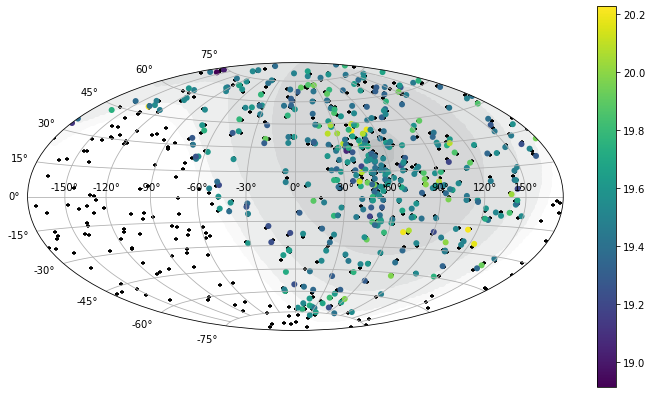

In [307]:
omega_det_coord = uv_to_coord(omega_det_exp_limited)
lons_det = np.pi - omega_det_coord.galactic.l.rad
lats_det = omega_det_coord.galactic.b.rad

# create a scatter plot of the particles
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection='hammer')

# # exposure
from matplotlib import colors
from fancy.plotting.colours import lightgrey, grey, white

exp_cmap = colors.LinearSegmentedColormap.from_list('custom', 
                                                        [lightgrey, grey], N = 6)
norm_proj = colors.Normalize(exposure_factor.min(), exposure_factor.max())

# fig = plt.figure(figsize=(12,7))
# ax = plt.subplot(111, projection='hammer')

for dec, proj in np.nditer([declinations, exposure_factor]):
    decs = np.tile(dec, num_points)
    c = SkyCoord(ra = rightascensions * u.rad,
                 dec = decs * u.rad, frame = 'icrs')
    lon = np.pi - c.galactic.l.rad
    lat = c.galactic.b.rad
    if (proj == 0):
        ax.scatter(lon, lat, linewidth = 3,
                       color = white, alpha = 1)
    else:
        ax.scatter(lon, lat, linewidth = 3,
                       color = exp_cmap(norm_proj(proj)), alpha = 1)
        
ax.scatter(-lons, lats, c="k", marker="+", s=10.0)
sc = ax.scatter(lons_det, lats_det, c=np.log10(Edet), lw=0)
ax.grid()
fig.colorbar(sc);


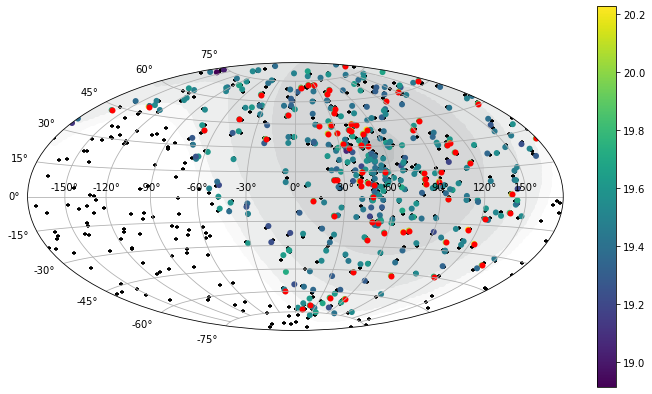

In [308]:
# omega_det_coord = uv_to_coord(omega_det_exp_limited)
# lons_det = np.pi - omega_det_coord.galactic.l.rad
# lats_det = omega_det_coord.galactic.b.rad

indices = np.argwhere(Edet * 1e-18 > 52)
Edet_th = Edet[indices]
lons_det_th = lons_det[indices]
lats_det_th = lats_det[indices]

# create a scatter plot of the particles
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection='hammer')

# # # exposure
# from matplotlib import colors
# from fancy.plotting.colours import lightgrey, grey, white

# exp_cmap = colors.LinearSegmentedColormap.from_list('custom', 
#                                                         [lightgrey, grey], N = 6)
# norm_proj = colors.Normalize(exposure_factor.min(), exposure_factor.max())

# fig = plt.figure(figsize=(12,7))
# ax = plt.subplot(111, projection='hammer')

for dec, proj in np.nditer([declinations, exposure_factor]):
    decs = np.tile(dec, num_points)
    c = SkyCoord(ra = rightascensions * u.rad,
                 dec = decs * u.rad, frame = 'icrs')
    lon = np.pi - c.galactic.l.rad
    lat = c.galactic.b.rad
    if (proj == 0):
        ax.scatter(lon, lat, linewidth = 3,
                       color = white, alpha = 1)
    else:
        ax.scatter(lon, lat, linewidth = 3,
                       color = exp_cmap(norm_proj(proj)), alpha = 1)
        
ax.scatter(-lons, lats, c="k", marker="+", s=10.0)
sc = ax.scatter(lons_det, lats_det, c=np.log10(Edet), lw=0)
ax.scatter(lons_det_th, lats_det_th, c="r", lw=0)
ax.grid()
fig.colorbar(sc);


In [309]:
print(len(Edet_th))

78
